In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [6]:
# Load your dataframe
df = pd.read_csv('creditcard.csv')

scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

X = df.drop('Class', axis=1).values
y = df['Class'].values

# Perform undersampling
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

undersample_indices = np.random.choice(class_0_indices, size=len(class_1_indices), replace=False)
undersample_indices = np.concatenate([undersample_indices, class_1_indices])

X = X[undersample_indices]
y = y[undersample_indices]

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# List of activations to test
activations_list = [
    ('relu', 'relu', 'sigmoid'),
    ('leaky_relu', 'leaky_relu', 'sigmoid'),
    ('sigmoid', 'sigmoid', 'sigmoid'),
    ('relu', 'relu', 'tanh'),
    ('leaky_relu', 'leaky_relu', 'tanh'),
    ('tanh', 'tanh', 'tanh'),
    ('linear', 'linear', 'sigmoid')
]

# Dictionary to store results
results = {'activation': [], 'auprc': [], 'f1_score': [], 'precision': [], 'recall': []}

In [8]:
# Function to create and compile the model
def create_model(activation):
    input_shape = (X_train.shape[1], )
    model = Sequential([
        Input(shape=input_shape),
        Dense(65, kernel_initializer='he_normal', activation=activation[0]),
        Dropout(0.5),
        Dense(65, kernel_initializer='he_normal', activation=activation[1]),
        Dropout(0.5),
        Dense(1, kernel_initializer='he_normal', activation=activation[2])
    ])
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['precision','recall'])
    return model

# Loop through each activation combination
for activation in activations_list:
    # Create and compile the model
    model = create_model(activation)

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=700, epochs=40, shuffle=True, verbose=1)

    # Predict probabilities and classes for the validation set
    y_val_pred_prob = model.predict(X_val).ravel()
    y_val_pred_class = (y_val_pred_prob > 0.5).astype(int)

    # Calculate precision-recall curve and AUPRC
    precision, recall, _ = precision_recall_curve(y_val, y_val_pred_prob)
    auprc = auc(recall, precision)

    # Calculate F1 score
    f1 = f1_score(y_val, y_val_pred_class)

    # Store results
    results['activation'].append(activation)
    results['auprc'].append(auprc)
    results['f1_score'].append(f1)
    results['precision'].append(precision)
    results['recall'].append(recall)

    # Save the model
    #model_name = f"MLPmodel_{activation[0]}_{activation[1]}_{activation[2]}.keras"
    #model.save(model_name)

Epoch 1/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 1.1424 - precision: 0.5682 - recall: 0.8634 - val_loss: 0.7213 - val_precision: 0.5629 - val_recall: 0.9592
Epoch 2/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9773 - precision: 0.6041 - recall: 0.9000 - val_loss: 0.6715 - val_precision: 0.5802 - val_recall: 0.9592
Epoch 3/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0620 - precision: 0.5903 - recall: 0.8724 - val_loss: 0.6224 - val_precision: 0.5912 - val_recall: 0.9592
Epoch 4/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9837 - precision: 0.6133 - recall: 0.8579 - val_loss: 0.5786 - val_precision: 0.6093 - val_recall: 0.9388
Epoch 5/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8903 - precision: 0.6089 - recall: 0.8606 - val_loss: 0.5430 - val_precision: 0.6408 - val_recall: 0.9286
Epoch 6/40
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7749 - precision: 0.6513 - recall: 0.8820 - val_loss: 0.5148 - val_precision: 0.6594 - val_recall: 0.9286
Epoch 7/4

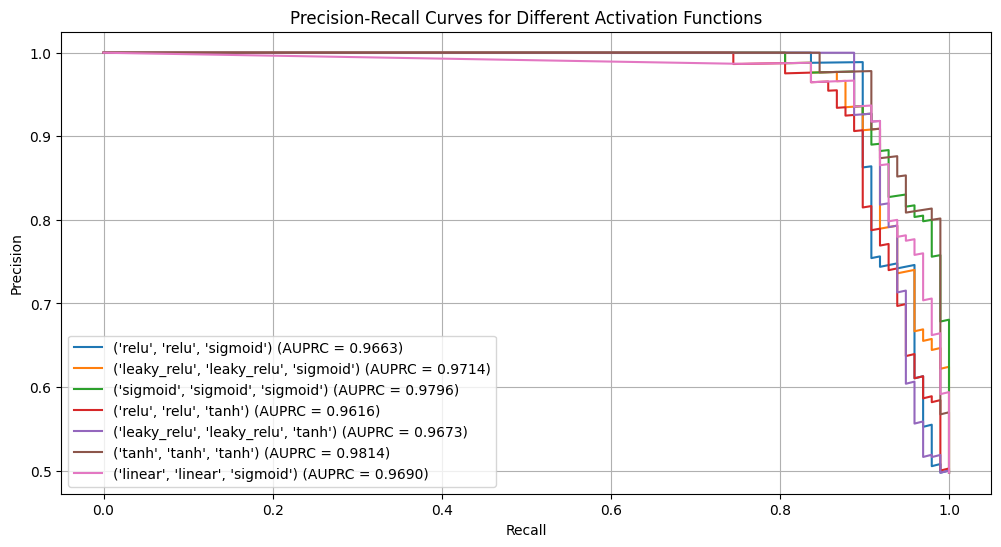

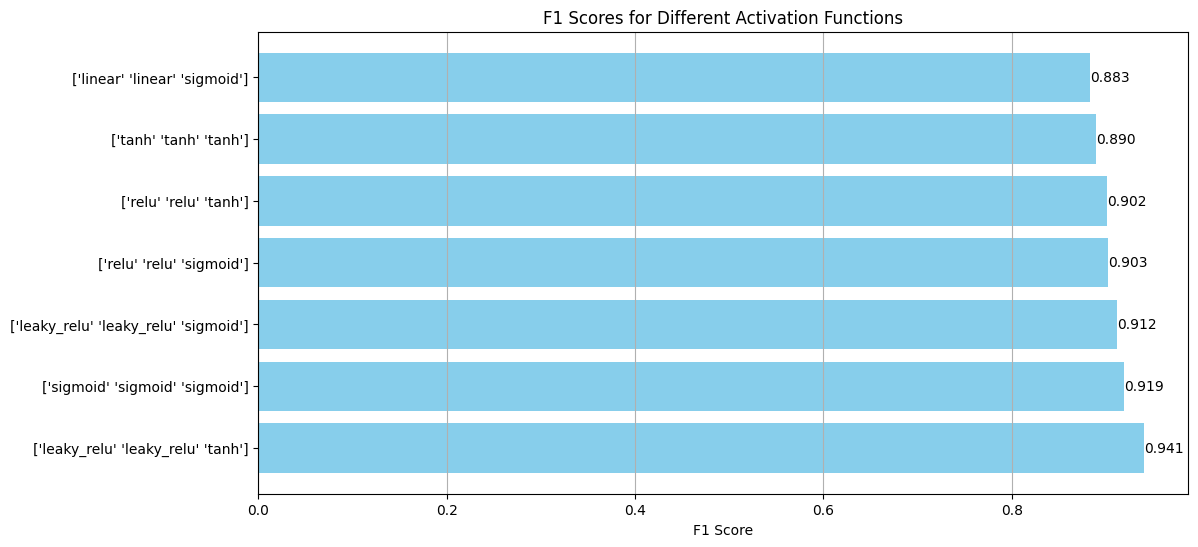

In [12]:
# Plotting all AUPRC curves
plt.figure(figsize=(12, 6))
for i in range(len(activations_list)):
    plt.plot(results['recall'][i], results['precision'][i], label=f'{results["activation"][i]} (AUPRC = {results["auprc"][i]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Activation Functions')
plt.legend()
plt.grid()
plt.show()

# Sort the F1 scores and activation functions in descending order
sorted_indices = np.argsort(results['f1_score'])[::-1]
sorted_f1_scores = np.array(results['f1_score'])[sorted_indices]
sorted_activations = np.array(results['activation'])[sorted_indices]

# Plot F1 scores
plt.figure(figsize=(12, 6))
bars = plt.barh([str(a) for a in sorted_activations], sorted_f1_scores, color='skyblue')
plt.xlabel('F1 Score')
plt.title('F1 Scores for Different Activation Functions')
plt.grid(axis='x')

# Annotate each bar with its F1 score value
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{sorted_f1_scores[i]:.3f}', 
             va='center', ha='left', color='black')

plt.show()

